<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/Lab_New_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Dataset and model

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from skimage.metrics import structural_similarity as ssim
import math
import cv2
import time
import os
from torchsummary import summary
from copy import deepcopy
import os


In [10]:
def save_checkpoint(epoch, model, optimizer, path): 
    state = { 'Epoch': epoch,
             'State_dict': model.state_dict(),
             'optimizer': optimizer.state_dict() 
             }
    torch.save(state, path)

In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device


In [12]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [13]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark
    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

 #   print(np.max(input)) check. 1임.
 #   print(np.min(input)) ---> 0
 #   print(np.min(output)) ----> 0

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [14]:
batch_size = 2048
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [ ]:
num_augmented_images = batch_size - 5
file_path = '/content/drive/MyDrive/Colab Notebooks/kodim'
file_names = os.listdir(file_path)
total_origin_image_num = len(file_names)
augment_cnt = 1 

In [ ]:
for i in range(1, num_augmented_images):
    change_picture_index = random.randrange(1, total_origin_image_num-1)
    print(change_picture_index)
    print(file_names[change_picture_index])
    file_name = file_names[change_picture_index]

    origin_image_path = 'custom_data\\kidim_augmented\\'+file_name
    print(origin_image_path)
    image = image.open(origin_image_path)
    random_augment = random.randrange(1,4)

Original Train/Validation/Test dataset

In [16]:
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.ToTensor(), download=True)
lab_test_set = torchvision.dataset.ImageFolFolder(root = "./content/")

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


Strong_hat Train/Validation/Test dataset


# Original / Gaussian Blur DataLoader

In [17]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)


In [18]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


# Model. Setting parameter -> float

In [19]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    
    self.encoder = nn.Sequential(
    # 96 by 96 by 3
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
    # 48 by 48 by 32
        nn.ReLU(True),



        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 
        nn.BatchNorm2d(128),
        nn.ReLU(True),


        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(256),
    # 6 by 6 by 256
        nn.ReLU(True),


        nn.Flatten(start_dim=1),
    )
    self.decoder = nn.Sequential(
        nn.Unflatten(dim=1,unflattened_size = (256,6,6)),
    # 6 by 6 by 256

        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

    # 12 by 12 by 128  
        
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),


    # 24 by 24 by 64
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(True),   
    
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(3),

    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Strong DAE train Mode

cuda
Epoch : [1/50] 

Training Loss: 0.047121	 validation Loss 0.028320
PNSR :10.74 	 SSIM : 0.42
PNSR :9.22 	 SSIM : 0.37
PNSR :8.16 	 SSIM : 0.36
PNSR :14.61 	 SSIM : 0.51
PNSR :13.13 	 SSIM : 0.49


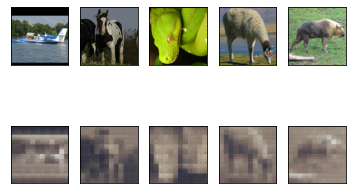

Epoch : [2/50] 

Training Loss: 0.020642	 validation Loss 0.021377
PNSR :12.31 	 SSIM : 0.54
PNSR :10.27 	 SSIM : 0.48
PNSR :9.85 	 SSIM : 0.34
PNSR :16.73 	 SSIM : 0.61
PNSR :15.13 	 SSIM : 0.57


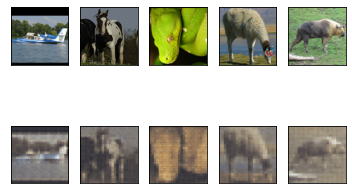

Epoch : [3/50] 

Training Loss: 0.015302	 validation Loss 0.019201
PNSR :12.55 	 SSIM : 0.58
PNSR :10.04 	 SSIM : 0.50
PNSR :9.99 	 SSIM : 0.41
PNSR :18.19 	 SSIM : 0.65
PNSR :15.31 	 SSIM : 0.61


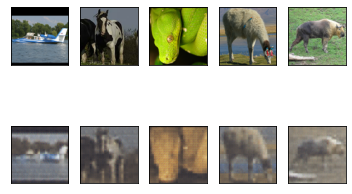

Epoch : [4/50] 

Training Loss: 0.012423	 validation Loss 0.017098
PNSR :12.96 	 SSIM : 0.66
PNSR :10.01 	 SSIM : 0.55
PNSR :10.30 	 SSIM : 0.45
PNSR :18.91 	 SSIM : 0.68
PNSR :15.98 	 SSIM : 0.66


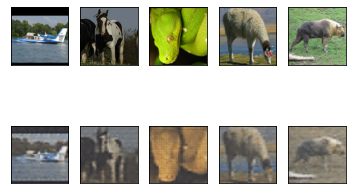

Epoch : [5/50] 

Training Loss: 0.010117	 validation Loss 0.014120
PNSR :14.28 	 SSIM : 0.70
PNSR :11.53 	 SSIM : 0.59
PNSR :11.13 	 SSIM : 0.46
PNSR :19.83 	 SSIM : 0.73
PNSR :16.63 	 SSIM : 0.70


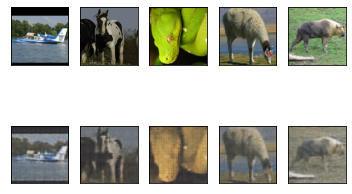

Epoch : [6/50] 

Training Loss: 0.008517	 validation Loss 0.012097
PNSR :14.24 	 SSIM : 0.72
PNSR :11.22 	 SSIM : 0.63
PNSR :11.58 	 SSIM : 0.44
PNSR :20.47 	 SSIM : 0.77
PNSR :18.09 	 SSIM : 0.70


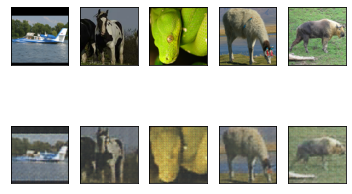

Epoch : [7/50] 

Training Loss: 0.007227	 validation Loss 0.010055
PNSR :15.41 	 SSIM : 0.74
PNSR :12.53 	 SSIM : 0.66
PNSR :13.24 	 SSIM : 0.48
PNSR :21.31 	 SSIM : 0.79
PNSR :18.91 	 SSIM : 0.74


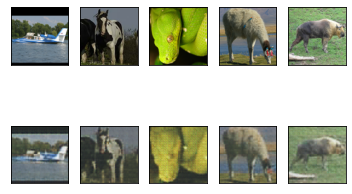

Epoch : [8/50] 

Training Loss: 0.006392	 validation Loss 0.008979
PNSR :15.81 	 SSIM : 0.75
PNSR :12.94 	 SSIM : 0.68
PNSR :13.75 	 SSIM : 0.51
PNSR :21.66 	 SSIM : 0.80
PNSR :19.36 	 SSIM : 0.75


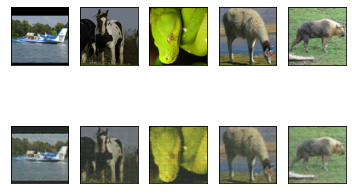

Epoch : [9/50] 

Training Loss: 0.005722	 validation Loss 0.007919
PNSR :16.19 	 SSIM : 0.76
PNSR :13.28 	 SSIM : 0.69
PNSR :14.00 	 SSIM : 0.54
PNSR :22.37 	 SSIM : 0.81
PNSR :19.98 	 SSIM : 0.77


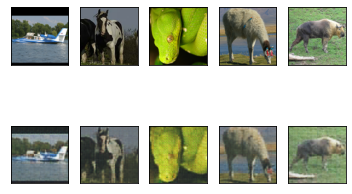

Epoch : [10/50] 

Training Loss: 0.005155	 validation Loss 0.007105
PNSR :17.01 	 SSIM : 0.78
PNSR :14.18 	 SSIM : 0.71
PNSR :14.86 	 SSIM : 0.56
PNSR :22.73 	 SSIM : 0.83
PNSR :20.31 	 SSIM : 0.78


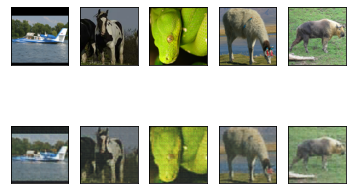

Epoch : [11/50] 

Training Loss: 0.004712	 validation Loss 0.006996
PNSR :17.22 	 SSIM : 0.78
PNSR :14.28 	 SSIM : 0.72
PNSR :14.90 	 SSIM : 0.56
PNSR :23.13 	 SSIM : 0.83
PNSR :20.17 	 SSIM : 0.79


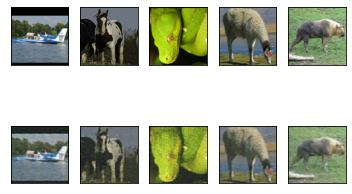

Epoch : [12/50] 

Training Loss: 0.004313	 validation Loss 0.006320
PNSR :17.19 	 SSIM : 0.79
PNSR :14.22 	 SSIM : 0.73
PNSR :15.81 	 SSIM : 0.58
PNSR :23.30 	 SSIM : 0.84
PNSR :20.17 	 SSIM : 0.79


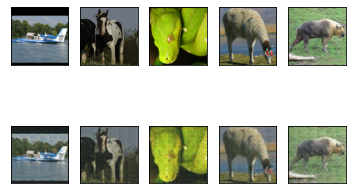

Epoch : [13/50] 

Training Loss: 0.004054	 validation Loss 0.006439
PNSR :17.35 	 SSIM : 0.79
PNSR :15.42 	 SSIM : 0.75
PNSR :14.80 	 SSIM : 0.58
PNSR :22.62 	 SSIM : 0.85
PNSR :18.33 	 SSIM : 0.79


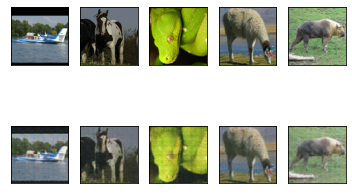

Epoch : [14/50] 

Training Loss: 0.003690	 validation Loss 0.005745
PNSR :18.31 	 SSIM : 0.80
PNSR :15.85 	 SSIM : 0.76
PNSR :15.92 	 SSIM : 0.59
PNSR :23.75 	 SSIM : 0.85
PNSR :20.22 	 SSIM : 0.80


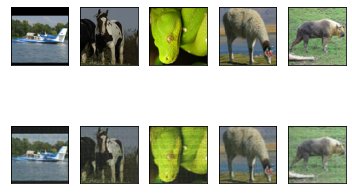

Epoch : [15/50] 

Training Loss: 0.003483	 validation Loss 0.004964
PNSR :18.66 	 SSIM : 0.81
PNSR :16.15 	 SSIM : 0.77
PNSR :16.98 	 SSIM : 0.61
PNSR :24.06 	 SSIM : 0.87
PNSR :21.12 	 SSIM : 0.82


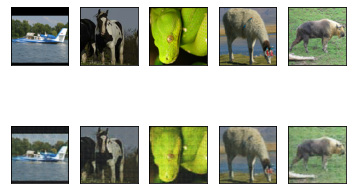

Epoch : [16/50] 

Training Loss: 0.003261	 validation Loss 0.005253
PNSR :18.45 	 SSIM : 0.81
PNSR :15.86 	 SSIM : 0.78
PNSR :16.40 	 SSIM : 0.61
PNSR :23.68 	 SSIM : 0.87
PNSR :20.71 	 SSIM : 0.82


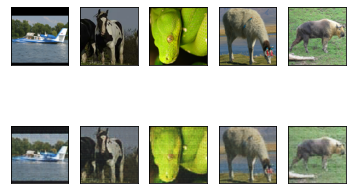

Epoch : [17/50] 

Training Loss: 0.003040	 validation Loss 0.005069
PNSR :18.44 	 SSIM : 0.81
PNSR :15.66 	 SSIM : 0.79
PNSR :16.63 	 SSIM : 0.62
PNSR :23.65 	 SSIM : 0.87
PNSR :21.08 	 SSIM : 0.82


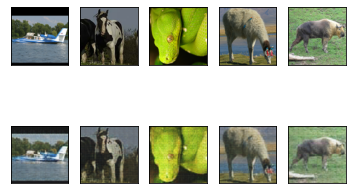

Epoch : [18/50] 

Training Loss: 0.002992	 validation Loss 0.004330
PNSR :19.66 	 SSIM : 0.82
PNSR :16.90 	 SSIM : 0.80
PNSR :18.33 	 SSIM : 0.65
PNSR :24.54 	 SSIM : 0.88
PNSR :21.85 	 SSIM : 0.84


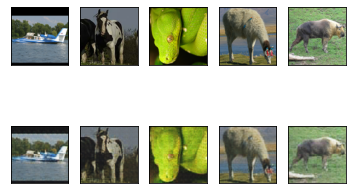

Epoch : [19/50] 

Training Loss: 0.002815	 validation Loss 0.004247
PNSR :19.71 	 SSIM : 0.82
PNSR :17.11 	 SSIM : 0.80
PNSR :18.79 	 SSIM : 0.64
PNSR :24.29 	 SSIM : 0.88
PNSR :21.09 	 SSIM : 0.84


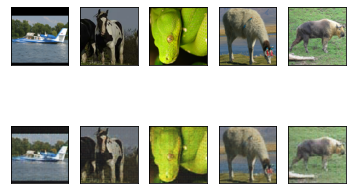

Epoch : [20/50] 

Training Loss: 0.002729	 validation Loss 0.004035
PNSR :19.88 	 SSIM : 0.82
PNSR :17.18 	 SSIM : 0.81
PNSR :18.39 	 SSIM : 0.64
PNSR :24.15 	 SSIM : 0.88
PNSR :21.31 	 SSIM : 0.84


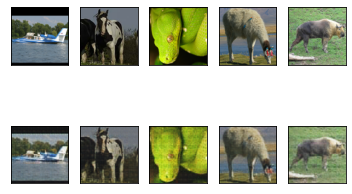

Epoch : [21/50] 

Training Loss: 0.002627	 validation Loss 0.003929
PNSR :19.89 	 SSIM : 0.82
PNSR :16.98 	 SSIM : 0.81
PNSR :18.92 	 SSIM : 0.65
PNSR :24.60 	 SSIM : 0.88
PNSR :21.72 	 SSIM : 0.84


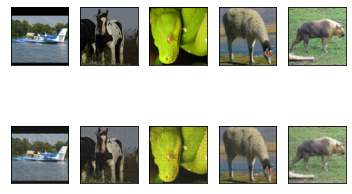

Epoch : [22/50] 

Training Loss: 0.002551	 validation Loss 0.003618
PNSR :19.84 	 SSIM : 0.83
PNSR :16.98 	 SSIM : 0.82
PNSR :18.97 	 SSIM : 0.66
PNSR :24.78 	 SSIM : 0.89
PNSR :22.14 	 SSIM : 0.85


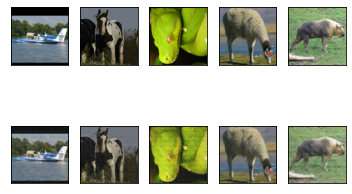

Epoch : [23/50] 

Training Loss: 0.002406	 validation Loss 0.003586
PNSR :21.05 	 SSIM : 0.83
PNSR :18.34 	 SSIM : 0.83
PNSR :20.66 	 SSIM : 0.65
PNSR :24.91 	 SSIM : 0.89
PNSR :22.03 	 SSIM : 0.85


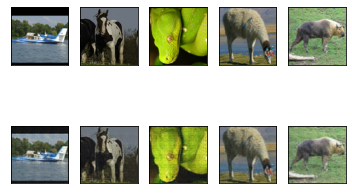

Epoch : [24/50] 

Training Loss: 0.002402	 validation Loss 0.003462
PNSR :20.82 	 SSIM : 0.84
PNSR :18.15 	 SSIM : 0.84
PNSR :20.38 	 SSIM : 0.67
PNSR :25.32 	 SSIM : 0.90
PNSR :21.95 	 SSIM : 0.85


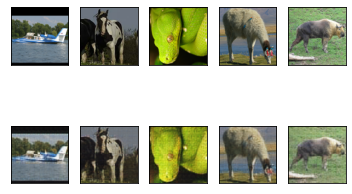

Epoch : [25/50] 

Training Loss: 0.002301	 validation Loss 0.003309
PNSR :20.96 	 SSIM : 0.84
PNSR :18.25 	 SSIM : 0.84
PNSR :20.40 	 SSIM : 0.67
PNSR :24.97 	 SSIM : 0.90
PNSR :22.21 	 SSIM : 0.86


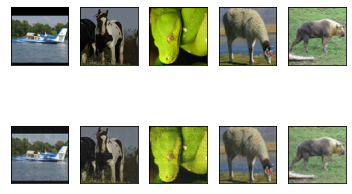

Epoch : [26/50] 

Training Loss: 0.002226	 validation Loss 0.003281
PNSR :21.22 	 SSIM : 0.84
PNSR :18.32 	 SSIM : 0.84
PNSR :21.60 	 SSIM : 0.66
PNSR :25.62 	 SSIM : 0.90
PNSR :22.62 	 SSIM : 0.86


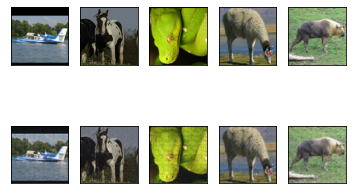

Epoch : [27/50] 

Training Loss: 0.002179	 validation Loss 0.003571
PNSR :21.34 	 SSIM : 0.83
PNSR :18.52 	 SSIM : 0.84
PNSR :21.46 	 SSIM : 0.66
PNSR :25.20 	 SSIM : 0.89
PNSR :21.61 	 SSIM : 0.85


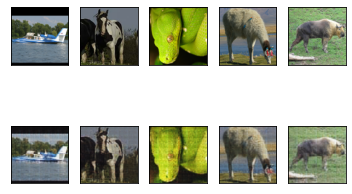

Epoch : [28/50] 

Training Loss: 0.002145	 validation Loss 0.003131
PNSR :21.24 	 SSIM : 0.83
PNSR :18.04 	 SSIM : 0.84
PNSR :20.37 	 SSIM : 0.65
PNSR :25.56 	 SSIM : 0.89
PNSR :22.90 	 SSIM : 0.85


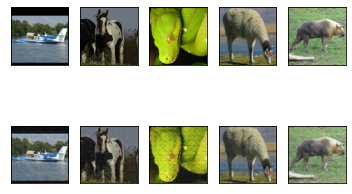

Epoch : [29/50] 

Training Loss: 0.002016	 validation Loss 0.003195
PNSR :21.47 	 SSIM : 0.84
PNSR :19.00 	 SSIM : 0.84
PNSR :21.29 	 SSIM : 0.67
PNSR :24.37 	 SSIM : 0.90
PNSR :22.09 	 SSIM : 0.86


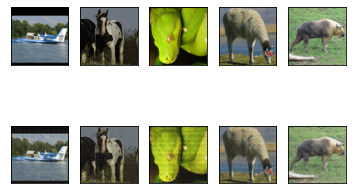

Epoch : [30/50] 

Training Loss: 0.002021	 validation Loss 0.003018
PNSR :21.41 	 SSIM : 0.85
PNSR :18.79 	 SSIM : 0.85
PNSR :20.20 	 SSIM : 0.68
PNSR :25.00 	 SSIM : 0.90
PNSR :21.85 	 SSIM : 0.86


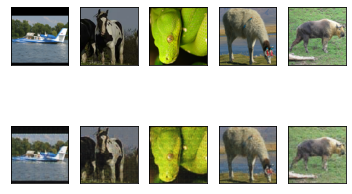

Epoch : [31/50] 

Training Loss: 0.001967	 validation Loss 0.002849
PNSR :22.01 	 SSIM : 0.85
PNSR :19.06 	 SSIM : 0.86
PNSR :22.41 	 SSIM : 0.69
PNSR :24.80 	 SSIM : 0.91
PNSR :22.21 	 SSIM : 0.87


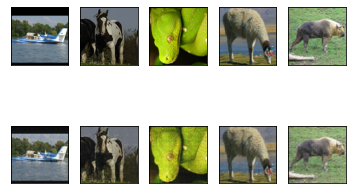

Epoch : [32/50] 

Training Loss: 0.001947	 validation Loss 0.002854
PNSR :21.54 	 SSIM : 0.85
PNSR :18.91 	 SSIM : 0.86
PNSR :20.77 	 SSIM : 0.68
PNSR :25.32 	 SSIM : 0.91
PNSR :21.89 	 SSIM : 0.87


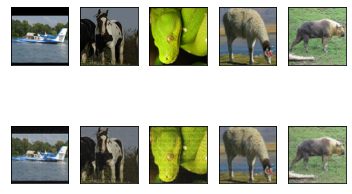

Epoch : [33/50] 

Training Loss: 0.001931	 validation Loss 0.002775
PNSR :22.75 	 SSIM : 0.85
PNSR :19.63 	 SSIM : 0.86
PNSR :22.33 	 SSIM : 0.68
PNSR :25.14 	 SSIM : 0.90
PNSR :22.49 	 SSIM : 0.86


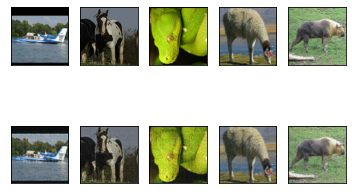

Epoch : [34/50] 

Training Loss: 0.001862	 validation Loss 0.002644
PNSR :22.76 	 SSIM : 0.85
PNSR :19.39 	 SSIM : 0.87
PNSR :21.70 	 SSIM : 0.70
PNSR :25.92 	 SSIM : 0.91
PNSR :22.97 	 SSIM : 0.87


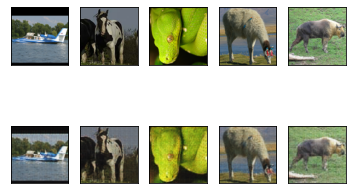

Epoch : [35/50] 

Training Loss: 0.001877	 validation Loss 0.002664
PNSR :22.47 	 SSIM : 0.85
PNSR :19.97 	 SSIM : 0.87
PNSR :22.48 	 SSIM : 0.69
PNSR :25.67 	 SSIM : 0.91
PNSR :22.73 	 SSIM : 0.87


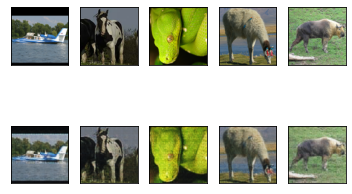

Epoch : [36/50] 

Training Loss: 0.001795	 validation Loss 0.002729
PNSR :22.51 	 SSIM : 0.85
PNSR :19.59 	 SSIM : 0.86
PNSR :22.03 	 SSIM : 0.69
PNSR :24.95 	 SSIM : 0.90
PNSR :22.33 	 SSIM : 0.86


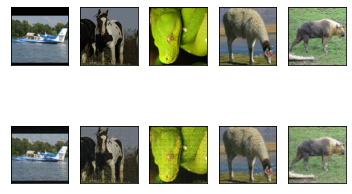

Epoch : [37/50] 

Training Loss: 0.001825	 validation Loss 0.002553
PNSR :22.38 	 SSIM : 0.85
PNSR :19.47 	 SSIM : 0.87
PNSR :21.82 	 SSIM : 0.71
PNSR :26.07 	 SSIM : 0.91
PNSR :22.88 	 SSIM : 0.88


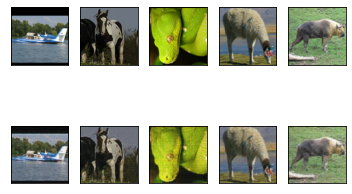

Epoch : [38/50] 

Training Loss: 0.001770	 validation Loss 0.002599
PNSR :22.42 	 SSIM : 0.85
PNSR :19.95 	 SSIM : 0.87
PNSR :21.93 	 SSIM : 0.70
PNSR :25.24 	 SSIM : 0.91
PNSR :22.50 	 SSIM : 0.87


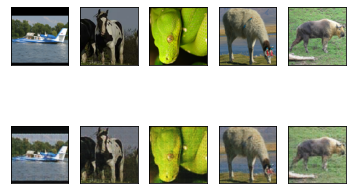

Epoch : [39/50] 

Training Loss: 0.001765	 validation Loss 0.002671
PNSR :22.57 	 SSIM : 0.85
PNSR :19.70 	 SSIM : 0.87
PNSR :21.54 	 SSIM : 0.70
PNSR :26.50 	 SSIM : 0.91
PNSR :22.74 	 SSIM : 0.87


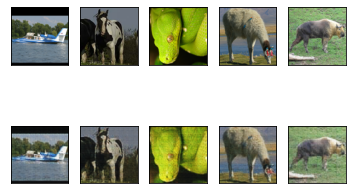

Epoch : [40/50] 

Training Loss: 0.001720	 validation Loss 0.002685
PNSR :22.90 	 SSIM : 0.85
PNSR :20.78 	 SSIM : 0.87
PNSR :23.00 	 SSIM : 0.69
PNSR :25.09 	 SSIM : 0.90
PNSR :21.56 	 SSIM : 0.87


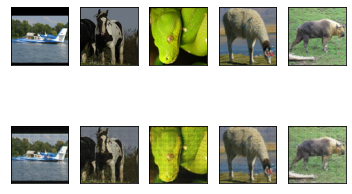

Epoch : [41/50] 

Training Loss: 0.001734	 validation Loss 0.002825
PNSR :21.42 	 SSIM : 0.84
PNSR :19.53 	 SSIM : 0.86
PNSR :20.61 	 SSIM : 0.69
PNSR :25.11 	 SSIM : 0.91
PNSR :21.70 	 SSIM : 0.87


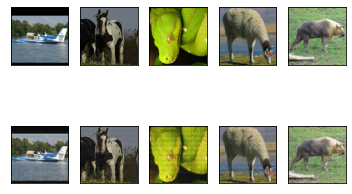

Epoch : [42/50] 

Training Loss: 0.001716	 validation Loss 0.002492
PNSR :22.62 	 SSIM : 0.86
PNSR :20.19 	 SSIM : 0.87
PNSR :20.91 	 SSIM : 0.71
PNSR :25.94 	 SSIM : 0.91
PNSR :23.14 	 SSIM : 0.88


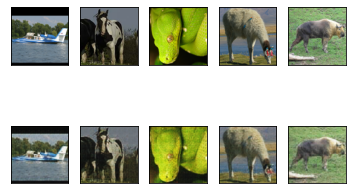

Epoch : [43/50] 

Training Loss: 0.001683	 validation Loss 0.002344
PNSR :23.44 	 SSIM : 0.86
PNSR :20.99 	 SSIM : 0.88
PNSR :22.65 	 SSIM : 0.71
PNSR :26.02 	 SSIM : 0.91
PNSR :22.57 	 SSIM : 0.87


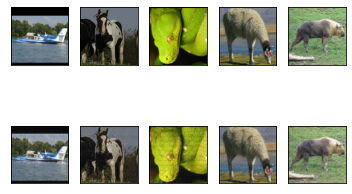

Epoch : [44/50] 

Training Loss: 0.001653	 validation Loss 0.002400
PNSR :22.88 	 SSIM : 0.86
PNSR :20.58 	 SSIM : 0.88
PNSR :22.16 	 SSIM : 0.72
PNSR :25.49 	 SSIM : 0.92
PNSR :22.72 	 SSIM : 0.88


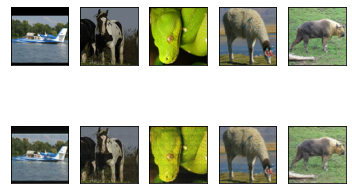

Epoch : [45/50] 

Training Loss: 0.001654	 validation Loss 0.002368
PNSR :23.27 	 SSIM : 0.86
PNSR :20.99 	 SSIM : 0.88
PNSR :22.58 	 SSIM : 0.72
PNSR :25.74 	 SSIM : 0.92
PNSR :22.58 	 SSIM : 0.88


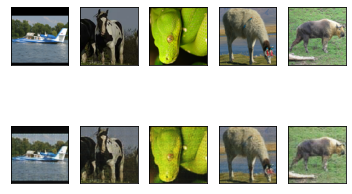

Epoch : [46/50] 

Training Loss: 0.001627	 validation Loss 0.002428
PNSR :22.74 	 SSIM : 0.86
PNSR :20.68 	 SSIM : 0.87
PNSR :21.51 	 SSIM : 0.72
PNSR :25.82 	 SSIM : 0.92
PNSR :22.68 	 SSIM : 0.88


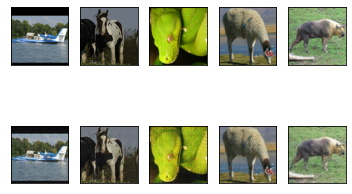

Epoch : [47/50] 

Training Loss: 0.001588	 validation Loss 0.002744
PNSR :22.41 	 SSIM : 0.85
PNSR :20.58 	 SSIM : 0.86
PNSR :21.43 	 SSIM : 0.69
PNSR :25.93 	 SSIM : 0.90
PNSR :23.01 	 SSIM : 0.87


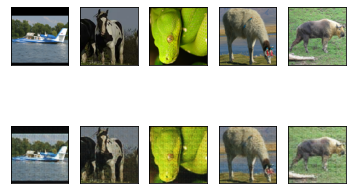

Epoch : [48/50] 

Training Loss: 0.001608	 validation Loss 0.002279
PNSR :23.19 	 SSIM : 0.86
PNSR :20.94 	 SSIM : 0.88
PNSR :23.40 	 SSIM : 0.73
PNSR :26.84 	 SSIM : 0.91
PNSR :23.16 	 SSIM : 0.88


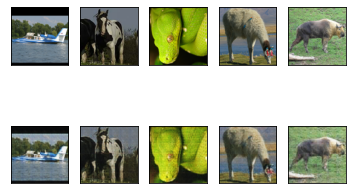

Epoch : [49/50] 

Training Loss: 0.001598	 validation Loss 0.002407
PNSR :22.71 	 SSIM : 0.86
PNSR :20.72 	 SSIM : 0.87
PNSR :22.41 	 SSIM : 0.71
PNSR :26.43 	 SSIM : 0.91
PNSR :22.76 	 SSIM : 0.88


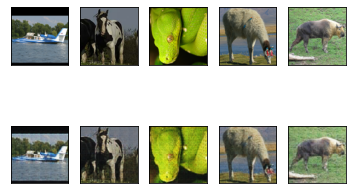

Epoch : [50/50] 

Training Loss: 0.001547	 validation Loss 0.002347
PNSR :22.85 	 SSIM : 0.86
PNSR :21.26 	 SSIM : 0.88
PNSR :22.53 	 SSIM : 0.72
PNSR :25.24 	 SSIM : 0.91
PNSR :21.68 	 SSIM : 0.87


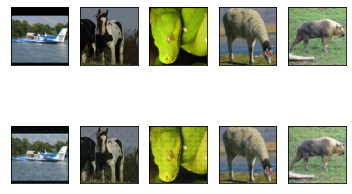

execution time : 22.3min


In [23]:

n_epochs = 50

device = get_device()
print(device)

model_strong = Autoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([])
strong_val_loss_graph = np.array([])




start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")
    model_strong.train()
    # monitor training loss
    train_loss = 0.0
    total_train_loss = 0.0
    val_loss = 0.0
    total_val_loss = 0.0

    '''
    Total되는 새로운 변수를 하나 만들어줘야지 val_loss가 제대로 더해진다. 안 하면 이상하게 안 더해진다.
    '''
    #Training
    for i,(tr_img, _) in enumerate(tr_dataloader):
#check   print(type(hat_tr_images))
        tr_img = tr_img.to(device)
#check   print(tr_images.shape)
        tr_outputs =model_strong(tr_img)
        optimizer_strong.zero_grad()
#check0. print(hat_tr_images.shape)  
#check   print(tr_outputs.shape)
        loss = mse_loss(tr_outputs, tr_img).to(device) #여기에 쿠다를 부착하니 성능 급 상승함.
        loss.backward()#.to(device)
        optimizer_strong.step()
        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

#check1.        print(f"minibatch : {i}, train_loss_added : {total_train_loss/1250}")
    total_train_loss = total_train_loss/len(tr_dataloader)
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    
    #evaluation
    model_strong.eval()
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (val_img, _) in enumerate(val_dataloader):
                val_img = val_img.to(device)
                val_outputs =model_strong(val_img)
#                print('val_outputs shape:',val_outputs.shape )
                val_loss = mse_loss(val_outputs, val_img)#.to(device)
                val_loss = val_loss.item()
                total_val_loss += val_loss
#check2.     print(f"val_mini_batch : {i }, val_loss_added : {total_val_loss/313}")                
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
#check3.     
        if (epoch)%1 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(2,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(2,5,j+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

## Epoch10일 때임. 

In [ ]:
from torchvision.utils import save_image

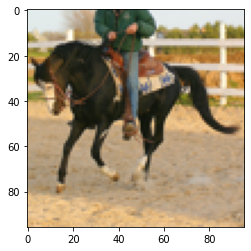

In [25]:
plt.imshow(test_img[0].cpu().detach().numpy().transpose(1,2,0))

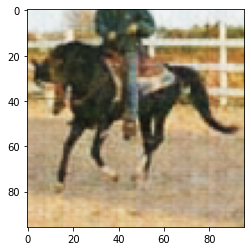

In [24]:
model_strong.eval()

test_img, _ = next(iter(test_dataloader))

test_img  = test_img.to(device)
model_strong = model_strong.to(device)
output = model_strong(test_img)
plt.imshow(output[0].cpu().detach().numpy().transpose(1,2,0))

In [ ]:
save_image(output[0],'output1.png')
save_image(test_img[0],'input1.png')


In [ ]:
summary(model_strong,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             416
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 64, 24, 24]           8,256
       BatchNorm2d-5           [-1, 64, 24, 24]             128
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7          [-1, 128, 12, 12]          32,896
       BatchNorm2d-8          [-1, 128, 12, 12]             256
              ReLU-9          [-1, 128, 12, 12]               0
           Conv2d-10            [-1, 256, 6, 6]         131,328
      BatchNorm2d-11            [-1, 256, 6, 6]             512
             ReLU-12            [-1, 256, 6, 6]               0
          Flatten-13                 [-1, 9216]               0
        Unflatten-14            [-1, 25

In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_strong.state_dict():
    print(param_tensor, "\t", model_strong.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer_strong.state_dict():
    print(var_name, "\t", optimizer_strong.state_dict()[var_name])

Model's state_dict:
encoder.0.weight 	 torch.Size([32, 3, 2, 2])
encoder.0.bias 	 torch.Size([32])
encoder.1.weight 	 torch.Size([32])
encoder.1.bias 	 torch.Size([32])
encoder.1.running_mean 	 torch.Size([32])
encoder.1.running_var 	 torch.Size([32])
encoder.1.num_batches_tracked 	 torch.Size([])
encoder.3.weight 	 torch.Size([64, 32, 2, 2])
encoder.3.bias 	 torch.Size([64])
encoder.4.weight 	 torch.Size([64])
encoder.4.bias 	 torch.Size([64])
encoder.4.running_mean 	 torch.Size([64])
encoder.4.running_var 	 torch.Size([64])
encoder.4.num_batches_tracked 	 torch.Size([])
encoder.6.weight 	 torch.Size([128, 64, 2, 2])
encoder.6.bias 	 torch.Size([128])
encoder.7.weight 	 torch.Size([128])
encoder.7.bias 	 torch.Size([128])
encoder.7.running_mean 	 torch.Size([128])
encoder.7.running_var 	 torch.Size([128])
encoder.7.num_batches_tracked 	 torch.Size([])
encoder.9.weight 	 torch.Size([256, 128, 2, 2])
encoder.9.bias 	 torch.Size([256])
encoder.10.weight 	 torch.Size([256])
encoder.10.bia

In [ ]:
1

1

In [ ]:
model_name = 'Gaussian_strong_debluring_model_renew'

path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{model_name}'

save_checkpoint(epoch, model_strong, optimizer_strong, path)

In [ ]:
#여기에 옵티마이저도 다시 로딩시켜야 한다.

epoch_300_model_name = 'Gaussian_strong_debluring_model'
path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{epoch_300_model_name}'

epoch_300_strong_load = DenosingAutoencoder()
epoch_300_optimizer =  torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
epoch_300_strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
epoch_300_strong_load = epoch_300_strong_load.to(device)

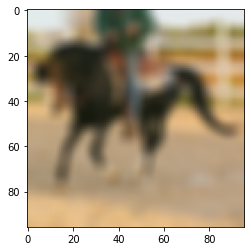

In [ ]:
epoch_300_strong_load.eval()

load_img,_ = next(iter(strong_hat_test_dataloader))
plt.imshow(load_img[0].numpy().transpose(1,2,0))

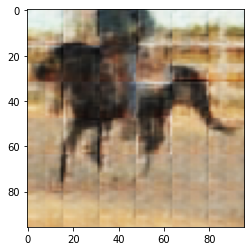

In [ ]:
load_img = load_img.to(device)
load_output_img = epoch_300_strong_load(load_img)
load_output_img.shape
plt.imshow(load_output_img[0].detach().cpu().numpy().transpose(1,2,0))


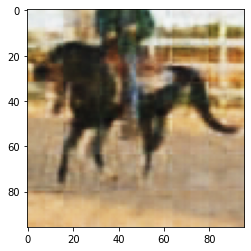

In [ ]:
load_img = load_img.to(device)
load_output_img = strong_load(load_img)
load_output_img.shape
plt.imshow(load_output_img[0].detach().cpu().numpy().transpose(1,2,0))


In [ ]:
model_name = 'Gaussian_strong_debluring_model_renew'
path = f'/content/drive/MyDrive/Colab Notebooks/saved_model/{model_name}'

device = torch.device("cuda")
strong_load = DenosingAutoencoder()
strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
strong_load_optimizer.load_state_dict(torch.load(path, map_location="cuda:0"))
strong_load = strong_load.to(device)

RuntimeError: ignored

In [ ]:
device = torch.device("cuda")
strong_load = DenosingAutoencoder()
strong_load.load_state_dict(torch.load(path, map_location="cuda:0"))  # 사용할 GPU 장치 번호를 선택합니다.
strong_load = strong_load.to(device)

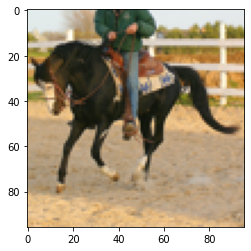

In [ ]:
load_origin_img,_ = next(iter(test_dataloader))
plt.imshow(load_origin_img[0].numpy().transpose(1,2,0))

In [ ]:
load_img[0].shape

torch.Size([3, 96, 96])

In [ ]:
load_img.shape

torch.Size([2048, 3, 96, 96])

# strong test

# strong graph

# test graph for (average psnr, ssim)

In [ ]:
from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))


NameError: ignored

In [ ]:
data = iter(Gs_blur_strong_val_dataloader)
img,_ = next(data)
img_uint8 = img[0].numpy().astype('uint8')

plt.imshow(img_uint8.transpose(1,2,0))
img[0]

In [ ]:
print(img[0].shape)